# Pandas 
Pandas is a popular python library for working with data through a `DataFrame`

In [8]:
!pip install tensorflow.contrib 

  ERROR: Could not find a version that satisfies the requirement tensorflow.contrib (from versions: none)
ERROR: No matching distribution found for tensorflow.contrib


In [12]:

import argparse

import numpy as np
import pandas as pd
import tensorflow as tf
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout, Input
from keras.models import Model
from keras.models import Sequential
from keras.optimizers import Adamax
from keras.utils import np_utils
from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model import utils
from tensorflow.python.saved_model import tag_constants, signature_constants
from tensorflow.python.saved_model.signature_def_utils_impl import build_signature_def, predict_signature_def
# from tensorflow.contrib.session_bundle import exporter

# parser = argparse.ArgumentParser()
# parser.add_argument('--csv_file', type=str, required=True)
# parser.add_argument('--export_path', type=str, required=True)
# # OPTIONAL
# parser.add_argument('--batch_size', type=int, default=1)
# parser.add_argument('--n_epochs', type=int, default=1)
# parser.add_argument('--debug', dest='debug', action='store_true')

#FLAGS = parser.parse_args()

batch_size_ = 10
n_epochs_ = 1
csv_file_ = "/Users/vkhota/Documents/School2019-20/eecs442/HW1/finalproject/fer2013.csv"
export_path_ = "./export"


# if (FLAGS.debug):
#     FLAGS.batch_size = 10
    
NUM_CLASSES = 7
IMG_SIZE = 48

# TODO: Use the 'Usage' field to separate based on training/testing
TRAIN_END = 28708
TEST_START = TRAIN_END + 1


def split_for_test(list):
    train = list[0:TRAIN_END]
    test = list[TEST_START:]
    return train, test


def pandas_vector_to_list(pandas_df):
    py_list = [item[0] for item in pandas_df.values.tolist()]
    return py_list


def process_emotion(emotion):
    """
    Takes in a vector of emotions and outputs a list of emotions as one-hot vectors.
    :param emotion: vector of ints (0-7)
    :return: list of one-hot vectors (array of 7)
    """
    emotion_as_list = pandas_vector_to_list(emotion)
    y_data = []
    for index in range(len(emotion_as_list)):
        y_data.append(emotion_as_list[index])

    # Y data
    y_data_categorical = np_utils.to_categorical(y_data, NUM_CLASSES)
    return y_data_categorical


def process_pixels(pixels, img_size=IMG_SIZE):
    """
    Takes in a string (pixels) that has space separated ints. Will transform the ints
    to a 48x48 matrix of floats(/255).
    :param pixels: string with space separated ints
    :param img_size: image size
    :return: array of 48x48 matrices
    """
    pixels_as_list = pandas_vector_to_list(pixels)

    np_image_array = []
    for index, item in enumerate(pixels_as_list):
        # 48x48
        data = np.zeros((img_size, img_size), dtype=np.uint8)
        # split space separated ints
        pixel_data = item.split()

        # 0 -> 47, loop through the rows
        for i in range(0, img_size):
            # (0 = 0), (1 = 47), (2 = 94), ...
            pixel_index = i * img_size
            # (0 = [0:47]), (1 = [47: 94]), (2 = [94, 141]), ...
            data[i] = pixel_data[pixel_index:pixel_index + img_size]

        np_image_array.append(np.array(data))

    np_image_array = np.array(np_image_array)
    # convert to float and divide by 255
    np_image_array = np_image_array.astype('float32') / 255.0
    return np_image_array


def get_vgg16_output(vgg16, array_input, n_feature_maps):
    vg_input = duplicate_input_layer(array_input, n_feature_maps)

    picture_train_features = vgg16.predict(vg_input)
    del (vg_input)

    feature_map = np.empty([n_feature_maps, 512])
    for idx_pic, picture in enumerate(picture_train_features):
        feature_map[idx_pic] = picture
    return feature_map


def duplicate_input_layer(array_input, size):
    vg_input = np.empty([size, 48, 48, 3])
    for index, item in enumerate(vg_input):
        item[:, :, 0] = array_input[index]
        item[:, :, 1] = array_input[index]
        item[:, :, 2] = array_input[index]
    return vg_input


def main():
    # used to get the session/graph data from keras
    K.set_learning_phase(0)
    # get the data in a Pandas dataframe
    raw_data = pd.read_csv(csv_file_)

    # convert to one hot vectors
    emotion_array = process_emotion(raw_data[['emotion']])
    # convert to a 48x48 float matrix
    pixel_array = process_pixels(raw_data[['pixels']])

    # split for test/train
    y_train, y_test = split_for_test(emotion_array)
    x_train_matrix, x_test_matrix = split_for_test(pixel_array)

    n_train = int(len(x_train_matrix))
    n_test = int(len(x_test_matrix))

    x_train_input = duplicate_input_layer(x_train_matrix, n_train)
    x_test_input = duplicate_input_layer(x_test_matrix, n_test)

    # vgg 16. include_top=False so the output is the 512 and use the learned weights
    vgg16 = VGG16(include_top=False, input_shape=(48, 48, 3), pooling='avg', weights='imagenet')

    # get vgg16 outputs
    x_train_feature_map = get_vgg16_output(vgg16, x_train_matrix, n_train)
    x_test_feature_map = get_vgg16_output(vgg16, x_test_matrix, n_test)

    # build and train model
    top_layer_model = Sequential()
    top_layer_model.add(Dense(256, input_shape=(512,), activation='relu'))
    top_layer_model.add(Dense(256, input_shape=(256,), activation='relu'))
    top_layer_model.add(Dropout(0.5))
    top_layer_model.add(Dense(128, input_shape=(256,)))
    top_layer_model.add(Dense(NUM_CLASSES, activation='softmax'))

    adamax = Adamax()

    top_layer_model.compile(loss='categorical_crossentropy',
                            optimizer=adamax, metrics=['accuracy'])

    # train
    top_layer_model.fit(x_train_feature_map, y_train,
                        validation_data=(x_train_feature_map, y_train),
                        nb_epoch=n_epochs_, batch_size=batch_size_)
    # Evaluate
    score = top_layer_model.evaluate(x_test_feature_map,
                                     y_test, batch_size=batch_size_)

    print("After top_layer_model training (test set): {}".format(score))

    # Merge two models and create the final_model_final_final
    inputs = Input(shape=(48, 48, 3))
    vg_output = vgg16(inputs)
    print("vg_output: {}".format(vg_output.shape))
    # TODO: the 'pooling' argument of the VGG16 model is important for this to work otherwise you will have to  squash
    # output from (?, 1, 1, 512) to (?, 512)
    model_predictions = top_layer_model(vg_output)
    final_model = Model(input=inputs, output=model_predictions)
    final_model.compile(loss='categorical_crossentropy',
                        optimizer=adamax, metrics=['accuracy'])
    final_model_score = final_model.evaluate(x_train_input,
                                             y_train, batch_size=batch_size_)
    print("Sanity check - final_model (train score): {}".format(final_model_score))

    final_model_score = final_model.evaluate(x_test_input,
                                             y_test, batch_size=batch_size_)
    print("Sanity check - final_model (test score): {}".format(final_model_score))
    # config = final_model.get_config()
    # weights = final_model.get_weights()

    # probably don't need to create a new model
    # model_to_save = Model.from_config(config)
    # model_to_save.set_weights(weights)
    model_to_save = final_model

    print("Model input name: {}".format(model_to_save.input))
    print("Model output name: {}".format(model_to_save.output))

    # Save Model
    builder = saved_model_builder.SavedModelBuilder(export_path_)
    signature = predict_signature_def(inputs={'images': model_to_save.input},
                                      outputs={'scores': model_to_save.output})
    with K.get_session() as sess:
        builder.add_meta_graph_and_variables(sess=sess,
                                             tags=[tag_constants.SERVING],
                                             signature_def_map={'predict': signature})
        builder.save()


if __name__ == "__main__":
    main()


58892288/58889256 [==============================] - 8s 0us/step


KeyboardInterrupt: 

In [1]:
import pandas as pd

Read the csv file using the pandas method **read_csv** which returns a **DataFrame** object

In [2]:
raw_data_csv_file_name = 'data/fer2013.csv'
raw_data = pd.read_csv(raw_data_csv_file_name)

FileNotFoundError: [Errno 2] File b'data/fer2013.csv' does not exist: b'data/fer2013.csv'

## **info()** for a quick description

In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
emotion    35887 non-null int64
pixels     35887 non-null object
Usage      35887 non-null object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


35887 entries

3 Columns
* pixels: **object**
* emotion: **int64**
* Usage: **object**

## head() for first 5 rows

In [6]:
raw_data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


* emotion: 0-6
* pixels: "ints separated by spaces" 
* Usage: "Training" // maybe others

## value_counts() for value counts

In [7]:
raw_data["Usage"].value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [8]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

def show_image_and_label(x, y):
    x_reshaped = x.reshape(48,48)
    plt.imshow(x_reshaped, cmap= "gray",
              interpolation="nearest")
    plt.axis("off")
    plt.show()
    print(y)

In [10]:
import numpy as np
# x_pixels
img = raw_data["pixels"][0]
val = img.split(" ")
x_pixels = np.array(val, 'float32')
x_pixels /= 255

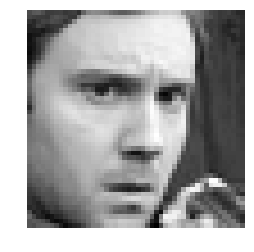

0


In [12]:
show_image_and_label(x_pixels, raw_data["emotion"][0])

(0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)